## Spotify API Customisation:

I decided to use the spotify API for my customisation and find information such as their top songs, albums and album lengths for different artists, depending on what the user inputs. 

In [1]:
#!pip install requests
#!pip install beautifulsoup4

In [5]:
import base64
import requests
import pandas as pd


def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = base64.b64encode(auth_bytes).decode("utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = requests.post(url, headers=headers, data=data)
    if result.status_code == 200:
        json_result = result.json()
        return json_result["access_token"]
    else:
        print("Error in getting token:", result.json())
        return None

def get_auth_header(token):
    return {"Authorization": "Bearer " + token}

def search_for_artist(token, artist_name):
    url = "https://api.spotify.com/v1/search"
    headers = get_auth_header(token)
    params = {
        "q": artist_name,
        "type": "artist",
        "limit": 1
    }
    result = requests.get(url, headers=headers, params=params)
    if result.status_code == 200:
        json_result = result.json()
        artists = json_result.get('artists', {}).get('items', [])
        return artists[0] if artists else None
    else:
        print("Failed to fetch artist:", result.json())
        return None

def get_songs_by_artist(token, artist_id):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks"
    headers = get_auth_header(token)
    params = {'country': 'US'}
    result = requests.get(url, headers=headers, params=params)
    if result.status_code == 200:
        json_result = result.json()
        return json_result.get('tracks', [])
    else:
        print("Failed to fetch songs:", result.json())
        return []

def get_album_details(token, album_id):
    url = f"https://api.spotify.com/v1/albums/{album_id}"
    headers = get_auth_header(token)
    result = requests.get(url, headers=headers)
    if result.status_code == 200:
        return result.json()
    else:
        print("Failed to fetch album details:", result.json())
        return None

def main():
    token = get_token()
    if not token:
        print("Could not get access token.")
        return

    artist_name = input("Enter your favorite artist's name: ")
    artist_result = search_for_artist(token, artist_name)
    if not artist_result:
        print("Artist not found.")
        return

    artist_id = artist_result["id"]
    tracks = get_songs_by_artist(token, artist_id)

    if not tracks:
        print("No tracks found for this artist.")
        return

    data = []
    for track in tracks:
        album_id = track['album']['id']
        album_details = get_album_details(token, album_id)
        if album_details:
            data.append({
                "Track Name": track["name"],
                "Album Name": album_details["name"],
                "Album Release Date": album_details["release_date"],
                "Track Duration (ms)": track["duration_ms"]
            })

    df = pd.DataFrame(data)
    file_name = "artist_details.csv"
    df.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")

if __name__ == "__main__":
    main()


Data saved to artist_details.csv


In [6]:
df = pd.read_csv("artist_details.csv")

df

,Track Name,Album Name,Album Release Date,Track Duration (ms)
0,Creep,Pablo Honey,1993-02-22,238640
1,No Surprises,OK Computer,1997-05-28,229120
2,Karma Police,OK Computer,1997-05-28,264066
3,Jigsaw Falling Into Place,In Rainbows,2007-12-28,248893
4,High and Dry,The Bends,1995-03-13,257480
5,Exit Music (For A Film),OK Computer,1997-05-28,267186
6,All I Need,In Rainbows,2007-12-28,228746
7,Let Down,OK Computer,1997-05-28,299560
8,Weird Fishes / Arpeggi,In Rainbows,2007-12-28,318186
9,Fake Plastic Trees,The Bends,1995-03-13,290706


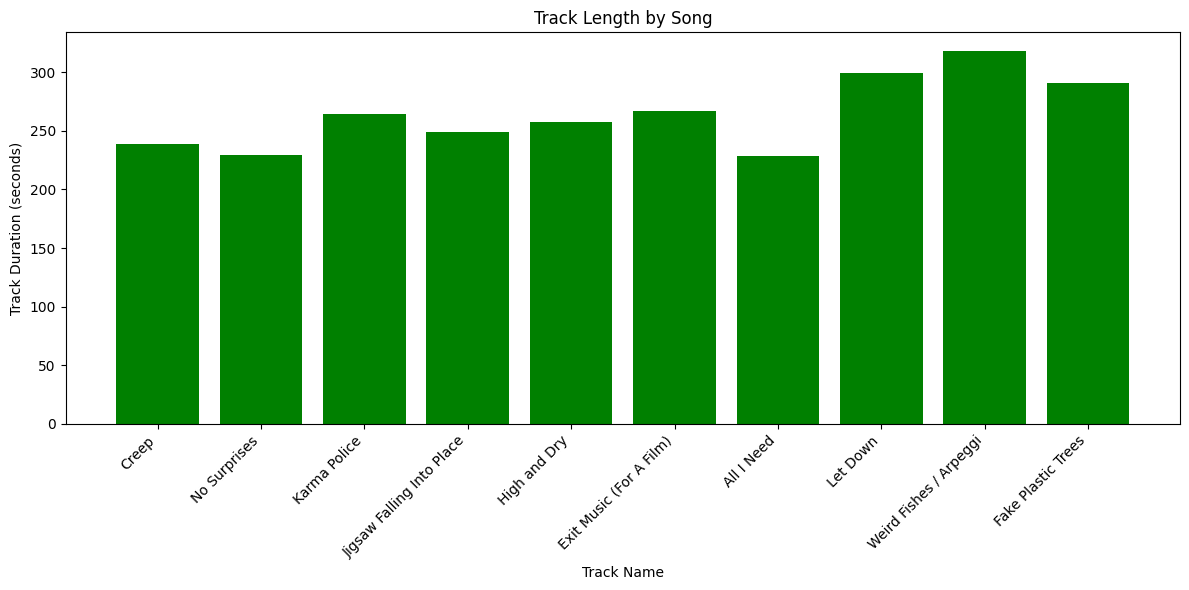

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


    
# Convert release date to datetime for better sorting
df['Album Release Date'] = pd.to_datetime(df['Album Release Date'])

# Plot track length over songs
plt.figure(figsize=(12, 6))
plt.bar(df['Track Name'], df['Track Duration (ms)'] / 1000, color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Track Name')
plt.ylabel('Track Duration (seconds)')
plt.title('Track Length by Song')
plt.tight_layout()
plt.show()



Data saved to artist_track_details.csv


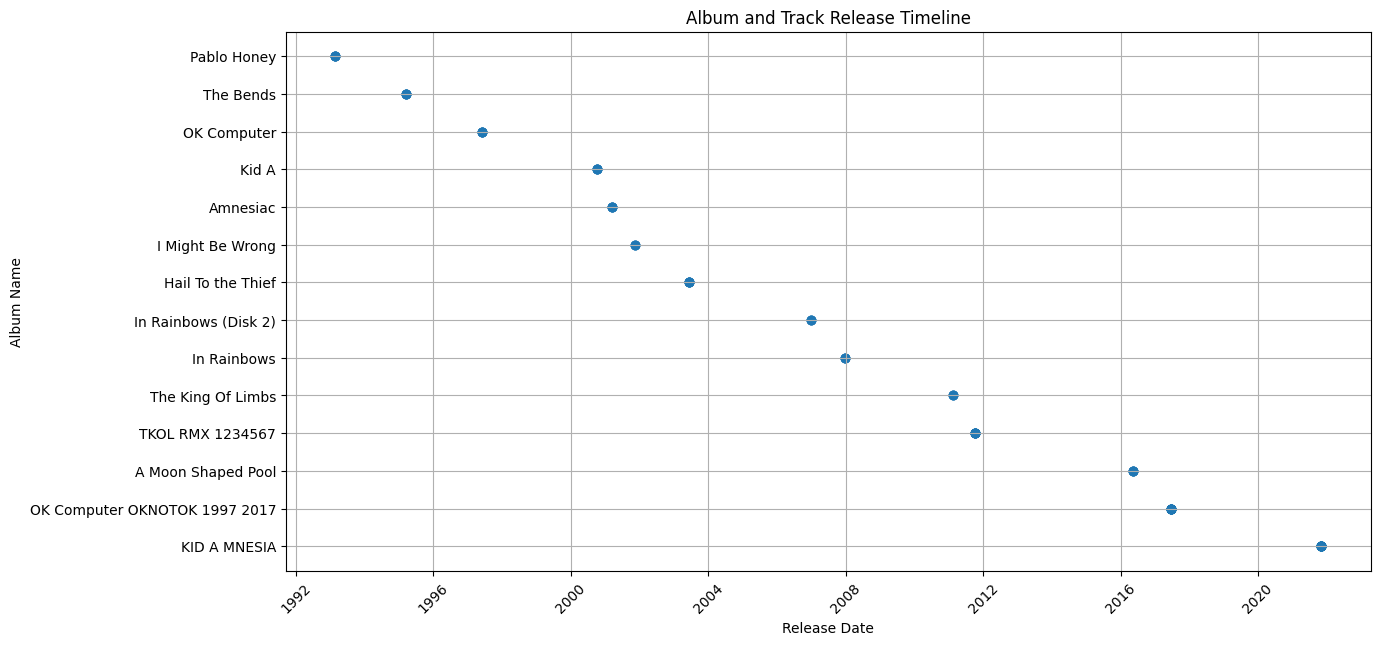

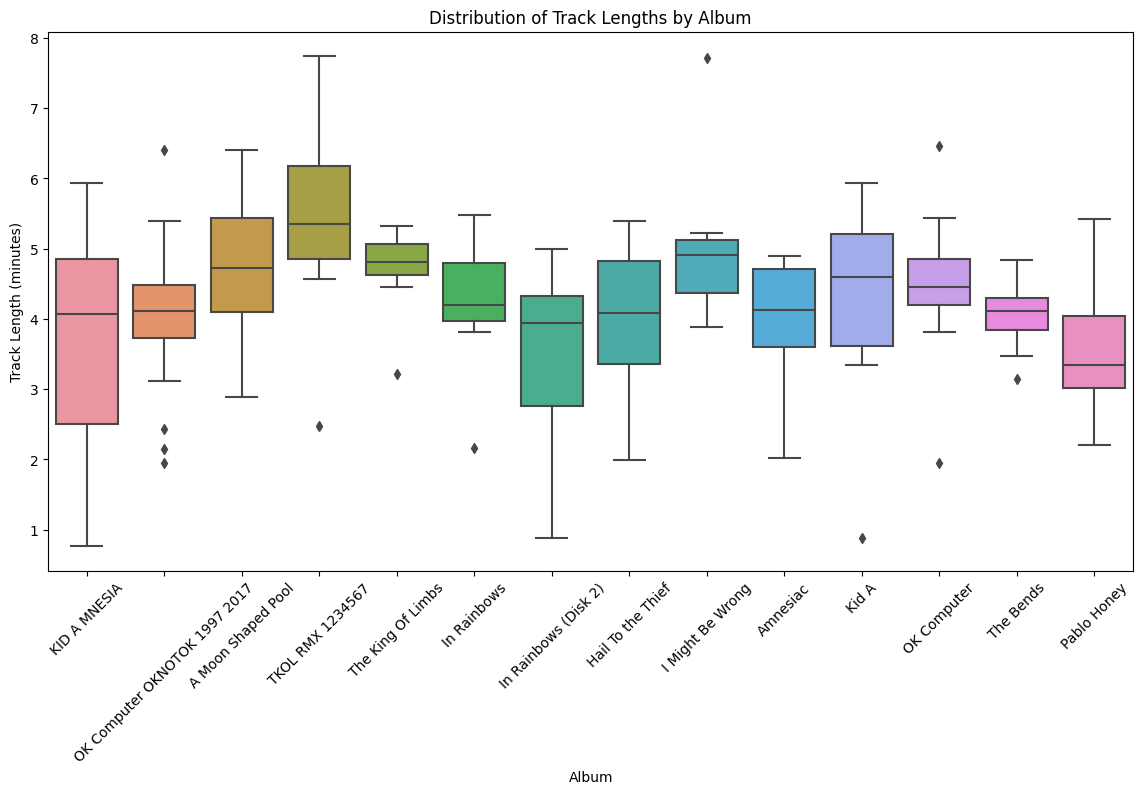

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Spotify API credentials
client_id = "c840fd19a7474ef4994110570ca008ba"
client_secret = "ffffddeba39f44dba9c48a354090420a"

def get_token():
    auth_string = f"{client_id}:{client_secret}"
    auth_bytes = auth_string.encode('utf-8')
    auth_base64 = base64.b64encode(auth_bytes).decode('utf-8')
    headers = {
        "Authorization": f"Basic {auth_base64}",
        "Content-Type": "application/x-www-form-urlencoded"
    }
    response = requests.post("https://accounts.spotify.com/api/token", headers=headers, data={"grant_type": "client_credentials"})
    response_data = response.json()
    return response_data.get("access_token")

def get_artist_id(token, artist_name):
    headers = {"Authorization": f"Bearer {token}"}
    params = {"q": artist_name, "type": "artist", "limit": 1}
    response = requests.get("https://api.spotify.com/v1/search", headers=headers, params=params)
    response_data = response.json()
    artists = response_data.get('artists', {}).get('items', [])
    return artists[0]['id'] if artists else None

def get_albums_and_tracks(token, artist_id):
    headers = {"Authorization": f"Bearer {token}"}
    albums = requests.get(f"https://api.spotify.com/v1/artists/{artist_id}/albums", headers=headers, params={"include_groups": "album", "limit": 50})
    albums_data = albums.json().get('items', [])
    
    track_details = []
    for album in albums_data:
        tracks_response = requests.get(f"https://api.spotify.com/v1/albums/{album['id']}/tracks", headers=headers, params={"limit": 50})
        tracks_data = tracks_response.json().get('items', [])
        for track in tracks_data:
            track_details.append({
                'album_name': album['name'],
                'album_release_date': album['release_date'],
                'track_name': track['name'],
                'track_length_ms': track['duration_ms']
            })
    return track_details

def save_to_csv(track_details, artist_name):
    df = pd.DataFrame(track_details)
    file_name = "artist_track_details.csv"
    df.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")
    return file_name

def visualize_data(track_details):
    # Check if track_details is not empty
    if not track_details:
        print("No track details available to visualize.")
        return

    # Create a DataFrame from track details
    df = pd.DataFrame(track_details)

    # Handle mixed date formats
    df['album_release_date'] = pd.to_datetime(df['album_release_date'], format='mixed', errors='coerce')
    df['track_length_min'] = df['track_length_ms'] / 60000  # Convert ms to minutes

    # Drop rows with invalid dates if any
    df = df.dropna(subset=['album_release_date'])

    # Check if DataFrame still has data after processing
    if df.empty:
        print("No valid data available to visualize after processing.")
        return

    # Plotting release timeline
    plt.figure(figsize=(14, 7))
    plt.scatter(df['album_release_date'], df['album_name'], alpha=0.5)
    plt.title('Album and Track Release Timeline')
    plt.xlabel('Release Date')
    plt.ylabel('Album Name')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


    # Plotting track lengths
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df, x='album_name', y='track_length_min')
    plt.title('Distribution of Track Lengths by Album')
    plt.xlabel('Album')
    plt.ylabel('Track Length (minutes)')
    plt.xticks(rotation=45)
    plt.show()

# Main execution block
token = get_token()
if token:
    artist_name = input("Enter your favorite artist's name: ")
    artist_id = get_artist_id(token, artist_name)
    if artist_id:
        track_details = get_albums_and_tracks(token, artist_id)
        file_name = save_to_csv(track_details, artist_name)
        visualize_data(track_details)
    else:
        print("Artist not found.")
else:
    print("Failed to retrieve token.")
